In [1]:
import os 

import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
import umap

import torch
from scvi.dataset import CsvDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer

import seaborn as sns
import matplotlib.pyplot as plt 

%matplotlib inline

In [73]:
!ls -lhtr /Users/dganguli/src/cellbench-scvi-stuffnthings/data

total 23776
-rw-r--r--  1 dganguli  staff    10K Dec 17 15:49 CellBench_scedrop_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   1.2M Dec 17 15:49 CellBench_scedrop_qc.csv.gz
-rw-r--r--  1 dganguli  staff    15K Dec 17 15:49 CellBench_sce4_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   2.0M Dec 17 15:49 CellBench_sce4_qc.csv.gz
-rw-r--r--  1 dganguli  staff    40K Dec 17 15:49 CellBench_sce10x_qc_cols.csv.gz
-rw-r--r--  1 dganguli  staff   6.8M Dec 17 15:49 CellBench_sce10x_qc.csv.gz
-rw-r--r--  1 dganguli  staff   1.5M Dec 18 14:09 scvi-stuffnthings.pkl


## Load 10X data

In [77]:
# loads a gene by cell expression matrix, anc a cell level annotation dataframe
base_path = '/Users/dganguli/src/cellbench-scvi-stuffnthings/data/'

def load_data(file_name, base_path=base_path):

    # data frame
    df = pd.read_csv(os.path.join(base_path, file_name))
    df.rename(columns = {"Unnamed: 0": "gene"}, inplace=True)

    # cell annotations
    cols_file_name = file_name.split('.csv')[0]+'_cols.csv.gz'
    cols = pd.read_csv(os.path.join(base_path, cols_file_name))
    
    return df, cols

def load_scvi_data(file_name, base_path=base_path):
    scvi_data = CsvDataset(file_name, save_path=base_path, compression="gzip", new_n_genes=600)
    return scvi_data

In [79]:
tenx, tenx_cols = load_data('CellBench_sce10x_qc.csv.gz')
drop, drop_cols = load_data('CellBench_scedrop_qc.csv.gz')

In [80]:
tenx.head()

,gene,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,...,CELL_000931,CELL_000932,CELL_000933,CELL_000934,CELL_000935,CELL_000939,CELL_000943,CELL_000946,CELL_000955,CELL_000965
0,ENSG00000272758,0,0,0,2,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
1,ENSG00000154678,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000148737,0,0,0,1,3,2,0,2,1,...,0,0,0,2,0,4,0,0,2,0
3,ENSG00000196968,0,0,0,1,2,2,5,0,4,...,0,0,0,0,0,2,0,0,0,0
4,ENSG00000134297,0,0,0,1,1,1,2,1,3,...,0,1,0,0,0,1,0,0,1,0


In [81]:
drop.head()

,gene,CELL_000001,CELL_000002,CELL_000003,CELL_000004,CELL_000005,CELL_000006,CELL_000007,CELL_000008,CELL_000009,...,CELL_000228,CELL_000229,CELL_000230,CELL_000231,CELL_000233,CELL_000237,CELL_000238,CELL_000246,CELL_000249,CELL_000302
0,ENSG00000223849,0,0,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ENSG00000225355,0,0,1,2,5,3,4,0,3,...,0,0,0,0,0,0,0,0,0,0
2,ENSG00000135093,0,0,0,0,3,2,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,ENSG00000183579,0,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ENSG00000138363,4,14,22,13,7,5,10,6,7,...,0,0,0,1,3,0,2,3,0,0


In [5]:
cols.cell_line.value_counts()

H2228     315
H1975     313
HCC827    274
Name: cell_line, dtype: int64

Text(0.5,1,'numer of genes per cell')

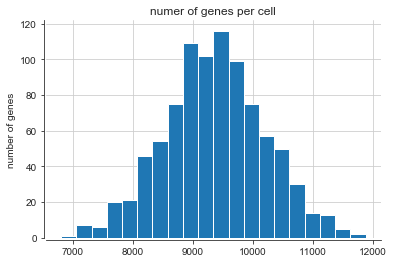

In [6]:
sns.set_style('ticks')
cols.number_of_genes.hist(bins=20)
sns.despine(offset=2)
plt.ylabel('number of genes')
plt.title('numer of genes per cell')

## Train model

### parameters

In [17]:
n_epochs_all = None
save_path = 'data/'
n_epochs=300 if n_epochs_all is None else n_epochs_all
lr=1e-3
use_batches=False
use_cuda=False

### train model

In [18]:
vae = VAE(scvi_data.nb_genes, n_batch=scvi_data.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              scvi_data,
                              train_size=0.75,
                              use_cuda=False,
                              frequency=5)

trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 300/300 [01:07<00:00,  4.46it/s]


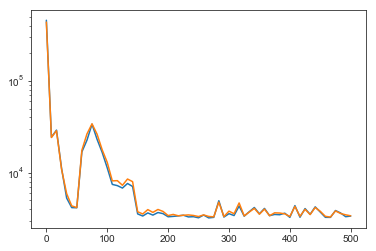

In [19]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.yscale('log')

### save model

In [20]:
model_name = 'scvi-stuffnthings.pkl'
final_state = vae.state_dict()
torch.save(final_state, os.path.join(base_path, model_name))

### load model

In [21]:
vae_loaded = VAE(scvi_data.nb_genes, n_batch=scvi_data.n_batches * use_batches)
vae_loaded.load_state_dict(torch.load(os.path.join(base_path, model_name)))

## visualize latent representations

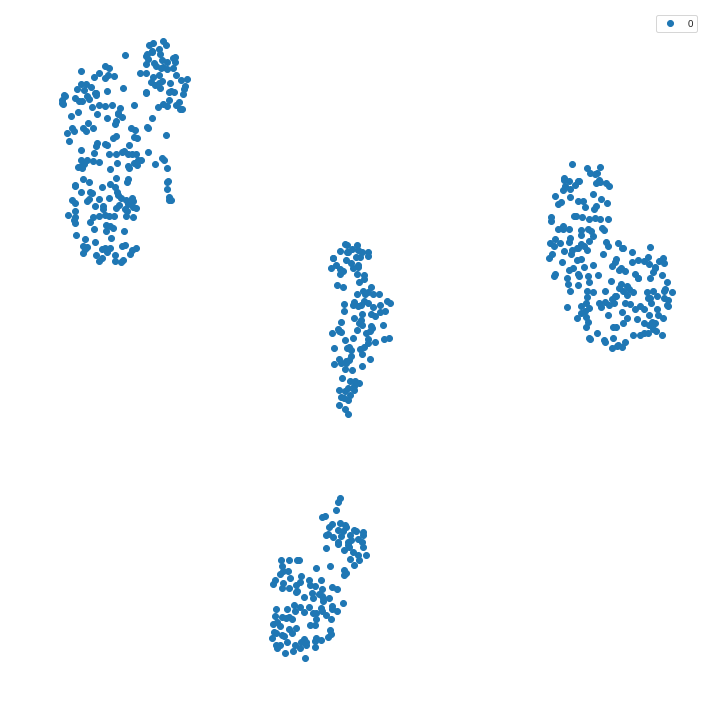

In [22]:
n_samples_tsne = 1000
trainer.train_set.show_t_sne(n_samples=n_samples_tsne, color_by='labels')

In [23]:
z, _, labels = trainer.train_set.get_latent(sample=False)

In [35]:
def umap_latent(z):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(z)
    embedding.shape
    plt.scatter(embedding[:,0], embedding[:,1])
    return embedding

[[-0.66141826 -0.51514375 -0.693975   ... -0.04581141 -0.18264121
   0.43245685]
 [-0.5464418  -0.11388212 -0.74545074 ...  0.7691558  -0.0528239
   0.0659112 ]
 [-0.6777775  -0.7393443  -0.95439273 ...  0.1415087  -1.0584674
  -0.1032441 ]
 ...
 [ 0.7939434   1.8669243  -2.9201896  ... -2.091733    0.5224781
  -0.23105672]
 [ 0.3891495  -0.50962114  0.91841286 ... -0.89785445 -1.3289452
   0.60180926]
 [-0.37355375 -0.928769   -0.29638684 ... -0.2760737  -1.5075908
  -0.11459765]]


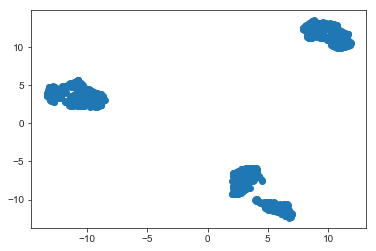

In [72]:
z = vae.sample_from_posterior_z(torch.tensor(scvi_data.X), give_mean=True)
z = z.detach().numpy()
print(z)
embedding = umap_latent(z)